# King County Real Estate - Predicting Home Prices

In this study, I'll be advising clients in King County, Washington who are interested in selling their homes. This study will answer two questions: 

- How much can improvements increase the value of a home?
- When is the best month of year in which to sell a home?

In order to determine the effect of improvements and month on home prices, I'm using home sale data to build a linear regression model that predicts the value of homes based on a range of variables. By including variables related to factors other than month and improvements in our model, we can determine with a higher degree of confidence how much these factors can raise home prices. 

The data set used for this model includes data on home sales in King County, Washington from May 2014 through May 2015.

In [1]:
#Importing necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Inspecting and Cleaning Data

In [2]:
#importing data set on King County 

df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#inspecting the columns for null values and type object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
#dropping unnecessary columns
df = df.drop(['id','lat', 'long'], axis=1)

### Engineering 'month' feature

In [6]:
#creating new column for 'month'.

df['month'] = df['date'].apply(lambda x: int(x.split('/')[0])).apply(lambda x: str(x))
df = df.drop('date', axis=1)

### Converting 'waterfront', 'view', 'condition' and 'grade' to numerical values 

In [7]:
#inspecting waterfront column
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [8]:
#converting waterfront column to binary values

df['waterfront'] = df['waterfront'].fillna('NO')
waterfront_dictionary = {'NO':0, 'YES':1}
df['waterfront'] = df['waterfront'].map(waterfront_dictionary)

In [9]:
#inspecting view column
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [10]:
#converting view column values to numerical 

df['view'] = df['view'].fillna('NONE')
view_dictionary = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}
df['view'] = df['view'].map(view_dictionary)

In [11]:
#inspecting condition column
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [12]:
#converting condition column values to numerical 
condition_dictionary = {'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(condition_dictionary)

In [13]:
#inspecting grade column

df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [14]:
#converting grade column values to numerical 

df['grade'] = df['grade'].apply(lambda x: x.split()[0]).astype(int)

### Cleaning 'sqft_basement' values and converting to binary

Since we expect multicollinearity between the the sqft_living variable, the sqft_above variable, and the sqft_basement variable, I'm converting sqft_basement to a binary variable 'basement,' which identifies whether or not there is a basement.

In [15]:
#inspecting sqft_basement column

df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [16]:
#converting sqft_basement values to numerical, labeling '?' values as zero 

df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else x)
df['sqft_basement'] = df['sqft_basement'].astype(float)


In [17]:
df['basement'] = df['sqft_basement'].apply(lambda x: 0 if x==0 else 1)
df = df.drop('sqft_basement', axis=1)

In [18]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,basement
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.00000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,2.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,1986.620318,12758.283512,0.38510
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,685.230472,27274.441950,0.48663
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,0.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,399.000000,651.000000,0.00000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,2.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,1490.000000,5100.000000,0.00000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,2.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,1840.000000,7620.000000,0.00000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,3.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,2360.000000,10083.000000,1.00000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,4.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,6210.000000,871200.000000,1.00000


### Engineering Renovation Features

In [19]:
#inspecting renovation value counts
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64

Because there are so many houses that have not been renovated, many houses have a 'yr_renovated' value of zero. I'm therefore going to bin renovations by the five year period during which they took place, including only the eight five year periods from the past forty years, since dates before this are unlikely to affect the value of a home.

<AxesSubplot:>

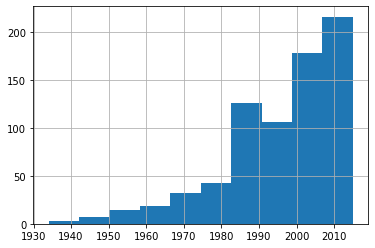

In [20]:
#inspecting renovation dates

df['yr_renovated'].loc[df['yr_renovated']!=0].hist()

In [21]:
#binning renovation dates from the past 40 years into eight five-year periods and encoding as binaries
#df['renovated'] =df['yr_renovated'].apply(lambda x: 0 if x==0 else 1)
df['renovated_2011_2015'] = df['yr_renovated'].apply(lambda x: 1 if x>=2011 else 0)
df['renovated_2006_2010'] = df['yr_renovated'].apply(lambda x: 1 if (x>=2006) & (x<2011) else 0)
df['renovated_2001_2005'] = df['yr_renovated'].apply(lambda x: 1 if (x>=2001) & (x<2006) else 0)
df['renovated_1996_2000'] = df['yr_renovated'].apply(lambda x: 1 if (x>=1996) & (x<2001) else 0)
df['renovated_1991_1995'] = df['yr_renovated'].apply(lambda x: 1 if (x>=1991) & (x<1996) else 0)
df['renovated_1986_1990'] = df['yr_renovated'].apply(lambda x: 1 if (x>=1986) & (x<1991) else 0)
df['renovated_1981_1985'] = df['yr_renovated'].apply(lambda x: 1 if (x>=1981) & (x<1986) else 0)
df['renovated_1976_1980'] = df['yr_renovated'].apply(lambda x: 1 if (x>=1976) & (x<1980) else 0)
df = df.drop('yr_renovated', axis=1)

### Converting zipcodes and months to dummy variables

In [22]:
#converting zipcodes to dummies.
df['zipcode'] = df['zipcode'].astype(str)
zipcode_dummies = pd.get_dummies(df['zipcode'], prefix='zip', drop_first=True)
df = df.drop('zipcode', axis=1)

In [23]:
#converting months to dummies, removing the first month to avoid multicollinearity. 

month_dummies = pd.get_dummies(df['month'], prefix='m', drop_first=True)
df = df.drop('month', axis=1)

### Adding month dummies to dataframe

For my baseline model, I'm leaving out zipcode dummies but after testing my baseline model, I'll add them to see how this improves the model's performance.

In [24]:
#data frame with dummies included

df = pd.concat([df, month_dummies], axis=1)

## Evaluating the baseline model

All data from the original data set (other than latitude and longitude) has now been converted to numerical or binary values. 
We're temporarily leaving zipcodes out of the model.

Before testing our baseline model, we'll look at:
- The distribution of the variables
- Correlation between variables

If variables have non-normal distributions we can improve our model by applying the log function to the variables.

If variables are highly correlated with each other, it means that we can't necessarily trust the coefficients associated with those variables since they may not be independent. However, the inclusion of collinear variables may still improve the performance of the model. 

### Distribution

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'basement'}>,
        <AxesSubplot:title={'center':'renovated_2011_2015'}>,
        <AxesSubplot:title={'center':'renovated_2006_2010'}>,
        <AxesSubplot:title={'center':'renovated_2001_2005'}>],
       [<AxesSubplot:title={'center':'reno

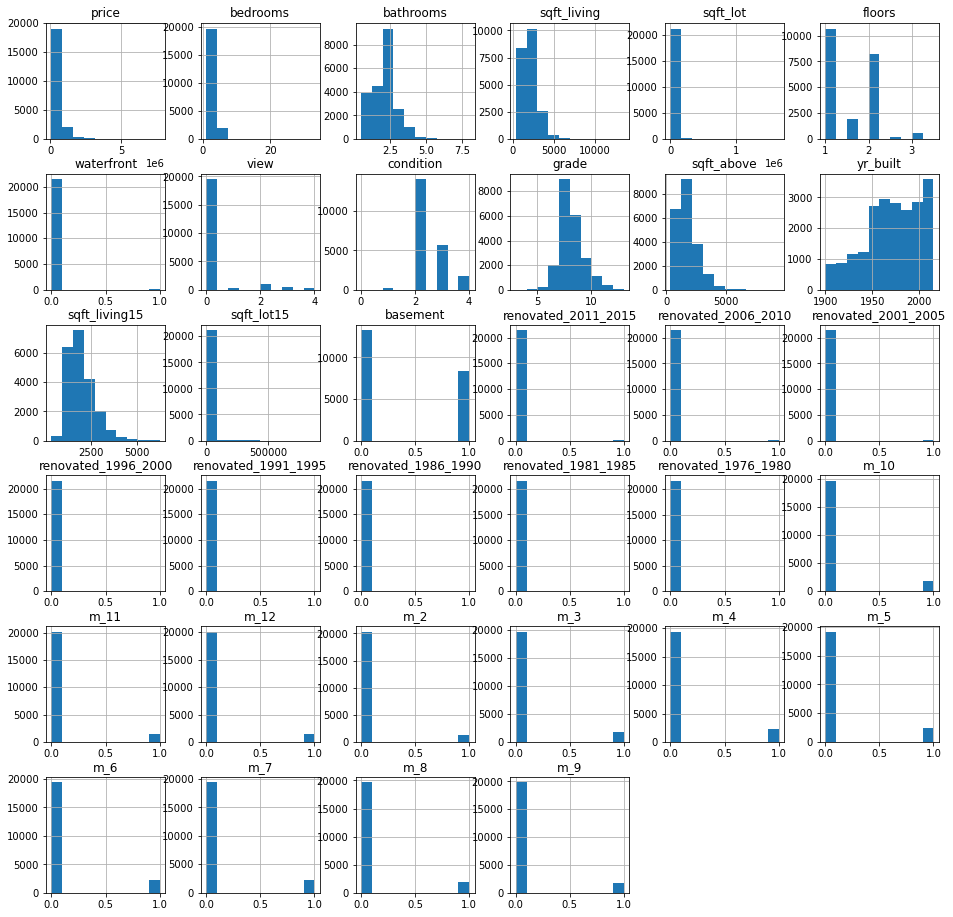

In [25]:
#inspecting distribution of variables
df.hist(figsize=(16,16))

We can see here that the target variable ('price') as well as all of the continuous predictive variables have non-normal distributions.

### Collinearity

In [26]:
#looking for collinearity of predictive variables
# code from https://github.com/learn-co-curriculum/dsc-multicollinearity-of-features
predictors = df.drop('price', axis=1)

predictor=predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)

predictor['pairs'] = list(zip(predictor.level_0, predictor.level_1))
predictor.set_index(['pairs'], inplace = True)
predictor.drop(columns=['level_1', 'level_0'], inplace = True)
predictor.columns = ['correlations']
predictor.drop_duplicates(inplace=True)

predictor[(predictor['correlations']<1)&(predictor['correlations']>=0.65)]

,correlations
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758
"(sqft_living15, sqft_above)",0.731767
"(sqft_lot, sqft_lot15)",0.718204
"(sqft_living15, grade)",0.713867
"(sqft_above, bathrooms)",0.686668


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def calc_vif(X):
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [28]:
df_plus_const = add_constant(df)
df_vif = calc_vif(df_plus_const)

/Users/davidrichter/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
df_vif.sort_values("VIF", ascending=False).head()

,variables,VIF
0,const,9383.879547
4,sqft_living,16.678695
11,sqft_above,15.755680
10,grade,3.710350
3,bathrooms,3.435160


It's unsurprising that sqft_living and sqft_above have a VIF of over 10 because sqft_above is directly dependent on sqft_living, basement, and floors and, in the case of the houses without a basement, should be identical to sqft_living.

Consequently, we'll leave sqft_above out of our model.

Because the other correlated variables can all move independently of each other, we'll leave them in place for now, but will check VIFs after converting continuous variables to logs and adding zipcode variables.

In [30]:
df = df.drop('sqft_above', axis=1)

## Fitting and evaluating the baseline model

In [31]:
from statsmodels.formula.api import ols
X = df.drop('price', axis=1)
outcome = 'price'
x_cols = list(X.columns)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     1290.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        16:47:55   Log-Likelihood:            -2.9584e+05
No. Observations:               21597   AIC:                         5.917e+05
Df Residuals:                   21564   BIC:                         5.920e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.132e+06   1.36e+05     45.202      0.000    5.87e+06     6.4e+06
bedrooms             -3.97e+04   2029.700    -19.557      0.000   -4.37e+04   -3.57e+04
bathrooms            4.413e+04   3518.557     12.543      0.000    3.72e+04     5.1e+04
sqft_living           161.1507      3.627     44.429      0.000     154.041     168.260
sqft_lot                0.0055      0.051      0.107      0.915      -0.095       0.106
floors                2.88e+04   3636.748      7.919      0.000    2.17e+04    3.59e+04
waterfront           6.168e+05   1.94e+04     31.747      0.000    5.79e+05    6.55e+05
view                 4.368e+04   2226.193     19.619      0.000    3.93e+04     4.8e+04
condition            2.232e+04   2486.087      8.976      0.000    1.74e+04    2.72e+04
grade                1.197e+05   2242.290     53.403      0.000    1.15e+05    1.24e+05
yr_built            -3537.6948     70.006    -50.534      0.000   -3674.912   -3400.478
sqft_living15          26.1341      3.566      7.329      0.000      19.145      33.124
sqft_lot15             -0.5601      0.078     -7.163      0.000      -0.713      -0.407
basement             8429.7780   3472.025      2.428      0.015    1624.352    1.52e+04
renovated_2011_2015  2.856e+04   1.88e+04      1.517      0.129   -8341.371    6.55e+04
renovated_2006_2010  1.382e+05   2.17e+04      6.378      0.000    9.57e+04    1.81e+05
renovated_2001_2005  1.185e+05   2.05e+04      5.787      0.000    7.84e+04    1.59e+05
renovated_1996_2000  1721.2984   2.39e+04      0.072      0.942   -4.51e+04    4.85e+04
renovated_1991_1995  4.308e+04   2.65e+04      1.624      0.104   -8924.277    9.51e+04
renovated_1986_1990 -1.394e+04   2.42e+04     -0.576      0.565   -6.13e+04    3.35e+04
renovated_1981_1985 -5.751e+04   2.87e+04     -2.006      0.045   -1.14e+05   -1314.460
renovated_1976_1980 -8.252e+04   5.09e+04     -1.621      0.105   -1.82e+05    1.72e+04
m_10                 3885.8611   8499.307      0.457      0.648   -1.28e+04    2.05e+04
m_11                -1587.9825   8968.532     -0.177      0.859   -1.92e+04     1.6e+04
m_12                -5029.1666   8890.824     -0.566      0.572   -2.25e+04    1.24e+04
m_2                  6365.8459   9203.610      0.692      0.489   -1.17e+04    2.44e+04
m_3                  3.397e+04   8497.858      3.998      0.000    1.73e+04    5.06e+04
m_4                  3.785e+04   8264.966      4.580      0.000    2.17e+04    5.41e+04
m_5                  1.348e+04   8168.724      1.650      0.099   -2535.207    2.95e+04
m_6                  3109.4551   8300.037      0.375      0.708   -1.32e+04    1.94e+04
m_7                  -919.0577   8280.159     -0.111      0.912   -1.71e+04    1.53e+04
m_8                  4155.8475   8454.223      0.492      0.623   -1.24e+04    2.07e+04
m_9

#### R-squared

With an R-squared value of 0.657, this baseline model accounts for almost two-thirds of the variance of our data set. 

#### Effect of Improvements

Significant positive effects are present for a number of variables associated with improvements:

- bathrooms
- sqft_living 
- condition
- grade
- renovated_2006_2010
- renovated_2001_2005


#### Effect of Sale Month

Significant effects are also present for houses sold during two months:

- march
- april

#### Skew and kurtosis

We have a high level of skew and kurtosis in this model, which means that there are a number of outliers, mostly in cases where the model is failing to predict prices of more expensive homes. To improve this model, we'll apply the log function to our continuous variables.

## Converting Continuous Data to Log Values

In [32]:
variables_to_log = ['sqft_living','sqft_lot', 'sqft_living15', 'sqft_lot15', 'price']

In [33]:
log_df = pd.DataFrame()
for v in variables_to_log:
    column_name = f'log_{v}'
    log_df[column_name] = df[v].apply(lambda x: 1 if x==0 else x).apply(np.log)

array([[<AxesSubplot:title={'center':'log_sqft_living'}>,
        <AxesSubplot:title={'center':'log_sqft_lot'}>],
       [<AxesSubplot:title={'center':'log_sqft_living15'}>,
        <AxesSubplot:title={'center':'log_sqft_lot15'}>],
       [<AxesSubplot:title={'center':'log_price'}>, <AxesSubplot:>]],
      dtype=object)

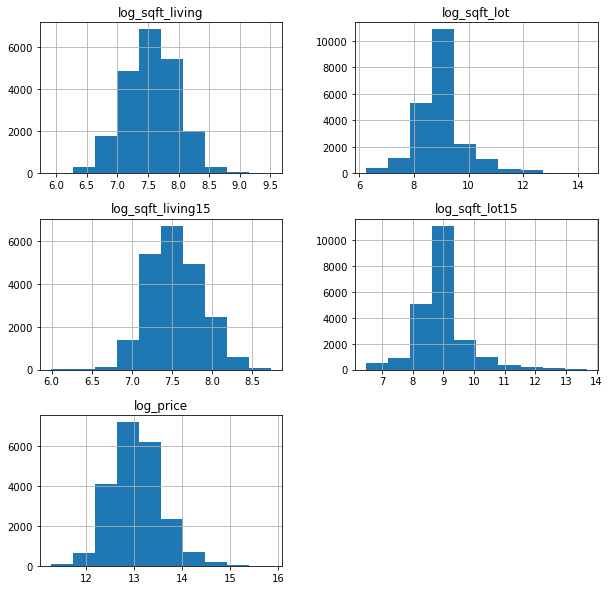

In [34]:
log_df.hist(figsize=(10, 10))

As we can see here, the distributions of the continuous variables are much more normally distributed now.

In [35]:
#dropping the original variables and adding the logged variables to the dataframe
df_with_logs = df.drop(variables_to_log, axis=1)
df_with_logs = pd.concat([df_with_logs, log_df], axis=1)

## Model #2: Continuous Variables as Logarithms

In [36]:
#Testing the model

X=df_with_logs.drop('log_price', axis=1)
outcome = 'log_price'
x_cols = list(X.columns)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_with_logs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     1345.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        16:47:56   Log-Likelihood:                -4941.2
No. Observations:               21597   AIC:                             9948.
Df Residuals:                   21564   BIC:                         1.021e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              18.3157      0.203     90.340      0.000      17.918      18.713
bedrooms               -0.0319      0.003    -10.697      0.000      -0.038      -0.026
bathrooms               0.0678      0.005     13.829      0.000       0.058       0.077
floors                  0.0791      0.006     13.974      0.000       0.068       0.090
waterfront              0.4079      0.027     14.839      0.000       0.354       0.462
view                    0.0457      0.003     14.567      0.000       0.040       0.052
condition               0.0461      0.004     13.078      0.000       0.039       0.053
grade                   0.2105      0.003     69.119      0.000       0.204       0.216
yr_built               -0.0056   9.84e-05    -56.431      0.000      -0.006      -0.005
basement                0.0598      0.005     11.479      0.000       0.050       0.070
renovated_2011_2015     0.0925      0.027      3.474      0.001       0.040       0.145
renovated_2006_2010     0.1390      0.031      4.537      0.000       0.079       0.199
renovated_2001_2005     0.0837      0.029      2.891      0.004       0.027       0.140
renovated_1996_2000     0.0451      0.034      1.336      0.182      -0.021       0.111
renovated_1991_1995     0.0626      0.038      1.668      0.095      -0.011       0.136
renovated_1986_1990    -0.0346      0.034     -1.012      0.311      -0.102       0.032
renovated_1981_1985    -0.0652      0.041     -1.607      0.108      -0.145       0.014
renovated_1976_1980    -0.0973      0.072     -1.352      0.176      -0.238       0.044
m_10                    0.0090      0.012      0.745      0.456      -0.015       0.033
m_11                    0.0028      0.013      0.225      0.822      -0.022       0.028
m_12                   -0.0038      0.013     -0.306      0.759      -0.028       0.021
m_2                     0.0121      0.013      0.933      0.351      -0.013       0.038
m_3                     0.0579      0.012      4.820      0.000       0.034       0.081
m_4                     0.0804      0.012      6.881      0.000       0.057       0.103
m_5                     0.0321      0.012      2.781      0.005       0.009       0.055
m_6                     0.0171      0.012      1.460      0.144      -0.006       0.040
m_7                     0.0115      0.012      0.982      0.326      -0.011       0.034
m_8                     0.0151      0.012      1.261      0.207      -0.008       0.038
m_9                     0.0068      0.012      0.559      0.576      -0.017       0.031
log_sqft_living         0.2879      0.012     24.574      0.000       0.265       0.311
log_sqft_lot           -0.0070      0.006     -1.158      0.247      -0.019       0.005
log_sqft_living15       0.2739      0.011     26.044      0.000       0.253       0.295
log

This improved the model by 1% overall, and by converting continuous variables to logarithms, we significantly improved our model for renovation date and sale month variables. Currently, we have significant positive coefficients for the following variables associated with improvements:

- bathrooms
- floors
- condition
- grade
- renovated_2011_2015
- renovated_2006_2010
- renovated_2001_2005

Meanwhile we now have significant positive coefficients for homes sold during three months

- march
- april
- may

Since we are now predicting the natural log of price, rather than price, the coefficients represent a multiplication of the baseline price by e^(beta*x). 

### Model Residuals - Homoskedasticity

Below we can see a low level of heteroskedasticity in our model, meaning that errors don't increase or decrease dramatically as the predicted target variable increases.

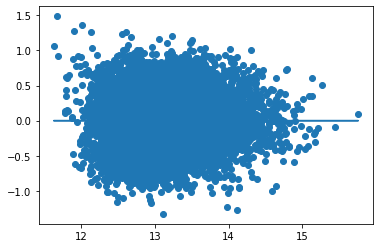

In [37]:
plt.scatter(model.predict(df_with_logs[x_cols]), model.resid)
plt.plot(model.predict(df_with_logs[x_cols]), [0 for i in range(len(df_with_logs))])

### Model Residuals - Normality

/Users/davidrichter/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


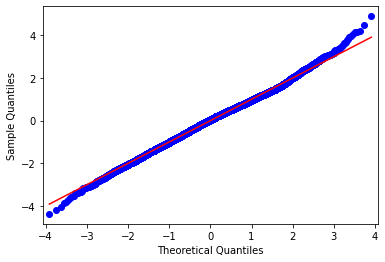

In [38]:
import scipy.stats as stats
import statsmodels.api as sm
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='s', fit=True)

As we can see from the qqplot above, this model's residuals have a nearly normally distribution, which we could have predicted from the model's low skew and kurtosis numbers.

## Adding Zipcodes to the Model

We'll next try to improve our model further by adding zipcode dummy variables.

In [39]:
df_with_zips = pd.concat([df_with_logs, zipcode_dummies], axis=1)

## Model #3: includes logged continuous variables and zipcodes

In [40]:
X=df_with_zips.drop('log_price', axis=1)
outcome = 'log_price'
x_cols = list(X.columns)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_with_zips).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1631.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        16:47:56   Log-Likelihood:                 6524.0
No. Observations:               21597   AIC:                        -1.284e+04
Df Residuals:                   21495   BIC:                        -1.203e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.6132      0.157     48.368      0.000       7.305       7.922
bedrooms               -0.0148      0.002     -8.333      0.000      -0.018      -0.011
bathrooms               0.0405      0.003     13.947      0.000       0.035       0.046
floors                 -0.0012      0.004     -0.348      0.728      -0.008       0.006
waterfront              0.4827      0.016     29.403      0.000       0.450       0.515
view                    0.0605      0.002     31.528      0.000       0.057       0.064
condition               0.0520      0.002     24.233      0.000       0.048       0.056
grade                   0.0994      0.002     51.036      0.000       0.096       0.103
yr_built               -0.0003   7.25e-05     -4.766      0.000      -0.000      -0.000
basement               -0.0407      0.003    -12.535      0.000      -0.047      -0.034
renovated_2011_2015     0.1177      0.016      7.488      0.000       0.087       0.148
renovated_2006_2010     0.1455      0.018      8.045      0.000       0.110       0.181
renovated_2001_2005     0.1031      0.017      6.029      0.000       0.070       0.137
renovated_1996_2000     0.0429      0.020      2.151      0.031       0.004       0.082
renovated_1991_1995     0.1025      0.022      4.627      0.000       0.059       0.146
renovated_1986_1990     0.0231      0.020      1.143      0.253      -0.016       0.063
renovated_1981_1985     0.0008      0.024      0.034      0.973      -0.046       0.048
renovated_1976_1980     0.0167      0.043      0.393      0.694      -0.067       0.100
m_10                   -0.0080      0.007     -1.132      0.258      -0.022       0.006
m_11                   -0.0070      0.007     -0.931      0.352      -0.022       0.008
m_12                   -0.0005      0.007     -0.073      0.942      -0.015       0.014
m_2                     0.0229      0.008      2.984      0.003       0.008       0.038
m_3                     0.0497      0.007      7.016      0.000       0.036       0.064
m_4                     0.0704      0.007     10.219      0.000       0.057       0.084
m_5                     0.0110      0.007      1.615      0.106      -0.002       0.024
m_6                     0.0030      0.007      0.435      0.664      -0.011       0.017
m_7                    -0.0039      0.007     -0.562      0.574      -0.017       0.010
m_8                    -0.0028      0.007     -0.396      0.692      -0.017       0.011
m_9                    -0.0085      0.007     -1.186      0.236      -0.023       0.006
log_sqft_living         0.3964      0.007     56.615      0.000       0.383       0.410
log_sqft_lot            0.0753      0.004     20.882      0.000       0.068       0.082
log_sqft_living15       0.1616      0.007     24.424      0.000       0.149       0.175
log

### Model Residuals - Homoskedasticity

Overall, the model's accuracy has improved significantly, accounting now for almost 90% of the variance in home prices. As with the last model heteroskedasticity is relatively low. 

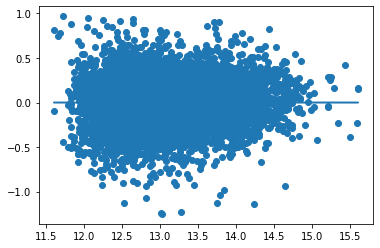

In [41]:
plt.scatter(model.predict(df_with_zips[x_cols]), model.resid)
plt.plot(model.predict(df_with_zips[x_cols]), [0 for i in range(len(df_with_zips))])

### Model Residuals - Normality

The model's residuals have a moderate level of kurtosis - 5.789 - as we can see from the following qqplot, which shows fat tails beyond two standard deviations from the mean. We can also see the negative skew of the residuals from the fact that the left side of the plot deviates more sharply from normal than the right side. This indicates that the even though the model reduced overall error, there are still significant outliers that are unaccounted for.

/Users/davidrichter/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


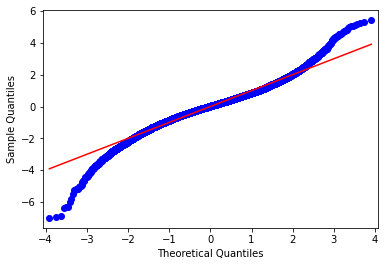

In [42]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='s', fit=True)

## Model Validation

In validating this model, I'll first use a single train test split to visualize how well the model predicts prices from a subset of test data after having been trained on a separate subset of training data. Next I'll use kfolds cross-validation to run tests on multiple splits of training and testing data to determine more definitively if the model overfits on training data.

#### Train test split

In [43]:
#Importing sklearn libraries to perform validation.

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg=LinearRegression()

y=df_with_zips[['log_price']]


In [44]:
#splitting the data into training and testing sets and fitting the model to the testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y)

linreg.fit(X, y)

y_predict = linreg.predict(X_test)

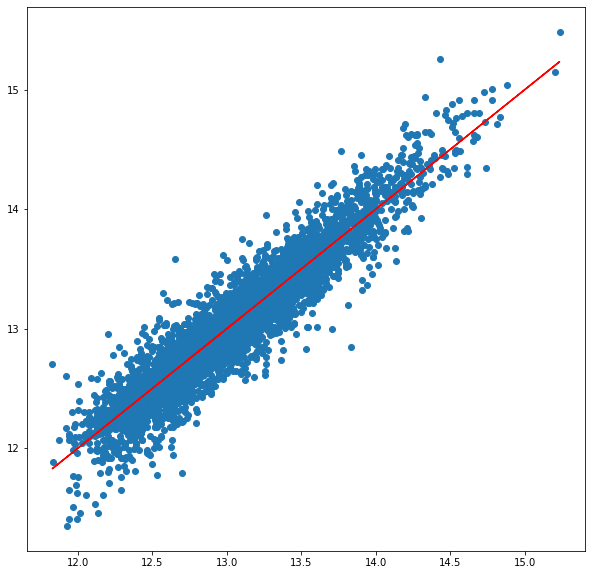

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_predict, y_test)
ax.plot(y_predict, y_predict, color='red')

Based on a single train-test-split, the model does not appear to be overfit, since the plot above shows a mostly tight distribution of actual prices around their predicted values.

#### Kfolds Cross Validation

In [46]:
cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='r2'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='r2'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='r2'))

In [47]:
print('cross validation, 5 folds:', cv_5_results)
print('cross validation, 10 folds:', cv_10_results)
print('cross validation, 20 folds:', cv_20_results)

cross validation, 5 folds: 0.881847479496735
cross validation, 10 folds: 0.8815515174907598
cross validation, 20 folds: 0.8820321275171311


The mean R-squared resulting from cross-validation is 0.3% lower than the R-squared of the model when it's fit on the data set as a whole, indicating that the model doesn't overfit on training data.

## Using Our Model for Inference

While this model shows low bias and variance, how useful is it for making the two types of inference that we're interested in?

- Best time of year to sell
- Effects of Improvements

We know that month variables don't have a significant correlation with other variables.

What about variables associated with improvement?

### Grade and Square Footage

As we see below, grade and square footage variables are highly correlated so we need to decide whether any of these variables should be eliminated from our model. 

In [48]:
#code from https://github.com/learn-co-curriculum/dsc-multicollinearity-of-features

predictors = df_with_zips.drop('log_price', axis=1)

predictor=predictors.corr().abs().stack().reset_index().sort_values(0, ascending=False)

predictor['pairs'] = list(zip(predictor.level_0, predictor.level_1))
predictor.set_index(['pairs'], inplace = True)
predictor.drop(columns=['level_1', 'level_0'], inplace = True)
predictor.columns = ['correlations']
predictor.drop_duplicates(inplace=True)

predictor[(predictor['correlations']<1)&(predictor['correlations']>=0.65)]

,correlations
pairs,
"(log_sqft_lot15, log_sqft_lot)",0.918665
"(bathrooms, log_sqft_living)",0.762135
"(log_sqft_living, log_sqft_living15)",0.746836
"(log_sqft_living, grade)",0.743038
"(grade, log_sqft_living15)",0.689054
"(grade, bathrooms)",0.665838


While log_sqft_lot15 and log_sqft_lot are highly correlated, we're not using these variables in recommendations to our clients so it doesn't matter if they're collinear as long as they are helping to improve the model.

We would also like to keep log_sqft_living15, since eliminating this variable might artificially inflate the coefficient for log_sqft_living.

We would also like to keep grade, bathrooms, and log_sqft_living variables - since these are important for inference. In order to determine how well we can trust the coefficients for these variables, we perform a VIF test on our data.

In [49]:
X = df_with_zips.drop('log_price', axis=1)
X_w_const = add_constant(X)
vif_df = calc_vif(X_w_const)

/Users/davidrichter/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
vif_df.sort_values('VIF', ascending=False).head()

,variables,VIF
0,const,16642.462370
30,log_sqft_lot,7.116730
32,log_sqft_lot15,7.010257
29,log_sqft_living,5.925898
7,grade,3.504237


The only inferential variable with a VIF above 5 is log_sqft_living. This is highly correlated with bathrooms, log_sqft_living15 and grade. Since all of these variables are positively correlated with price in our model, it's possible that their presence is artificially bringing down the value of the log_sqft_living coefficient. However, this should not be a problem for us because we're interested in giving customers conservative estimates of coefficients. 

It's extremely likely that the size of neighboring homes, the presence of additional bathrooms, and grade are all improving the value of homes indpendently of their size, so we want to make sure that we're not giving undue influence to size just because it's correlated with these other variables.

## Effect of Improvements

We can now use our model to calculate how a specific set of improvements are likely to impact a home's price based on the fitted model above. 

I include four types of improvements:

- renovated_2011_2015 (I take the effect of recent renovations as the most accurate representation of the effect of future renovations)
- grade
- condition
- bathroom
- log_sqft_living

The reason that I include these variables and not others is that they  all: 

1. Are within the owner's control

2. Have significant positive coefficients

Instead of including the model's coefficient in my calculations, I'm including the bottom of the 97.5 confidence interval, since it's important to give clients a conservative estimate of their potential returns.

In [51]:
print('minimum renovated_2011_2015 factor, 97.5% confidence: ', np.e**0.087)
print('minimum grade improvement factor, 97.5% confidence: ', np.e**0.096)
print('minimum condition improvement factor, 97.5% confidence: ', np.e**0.048)
print('minimum bathroom improvement factor, 97% confidence: ', np.e**0.035)
print('minimumum sqft_living improvement exponent, 97.5% confidence: ', 0.383)

minimum renovated_2011_2015 factor, 97.5% confidence:  1.0908966797182778
minimum grade improvement factor, 97.5% confidence:  1.1007590639939788
minimum condition improvement factor, 97.5% confidence:  1.0491706553244704
minimum bathroom improvement factor, 97% confidence:  1.0356197087996233
minimumum sqft_living improvement exponent, 97.5% confidence:  0.383


If we include the above variables in our model, we can calculate the factor by which incremental improvements in grade, condition, and proportional increase in living area increase the predicted price of a home:

price increase factor = f

incremental grade increase = g

incremental condition increase = c

incremental bathroom increase = b

proportional living area increase = l

f = 1.09*(1.10^g)*(1.05^c)*(1.04^b)*(l^0.383)

Let's say we have a home with current value cv = 200,000. We raise the grade of the home by 1 point, the condition by 1 point and the living space by 10%.

Then we have:

In [52]:
cv=200000

g = 1      # 1 point increase in grade
c = 1      # 1 point increase in condition
b = 1      # 1 additional bathroom
l = 1.1    # 10% increase in square footage

f = 1.09*(1.10**g)*(1.05**c)*(1.04**b)*(l**0.383)

print('predicted appreciation factor :', f)
print('new value of home :', f*cv)
print('confidence :', 0.975**5) #where 5 is the number of coefficients

predicted appreciation factor : 1.3579857724397717
new value of home : 271597.15448795434
confidence : 0.8810956933593749


## Model #4 - Removing renovation bins

Even though we have been including renovation bins in our model, renovation is significantly different from all of the other categories we're using for inference.

Adding a bathroom, increasing the square footage of a home, and improving a home's condition and grade -- these all make a measurable difference in the quality of a home. The same is not true of renovation. Renovations do entail a tangible improvement in a home's condition and grade, but in this case, the condition and grade variables should be able to do all the work that the renovation variable is doing. There are three non-exclusive possibilities for what this variable is doing in our model:

1. It could be doing work that could be done by condition and grade variables.
2. The knowledge that a house has been renovated could increase its value to buyers independently of the quality of renovations.
3. There could be a correlation between renovation and more expensive zipcodes that isn't showing up because zipcodes are each given their own variable.

Because of this uncertainty we'll remove renovation bins from our model and see how it performs.

In [53]:
ren_bins = ['renovated_2011_2015', 'renovated_2006_2010',\
            'renovated_2001_2005', 'renovated_1996_2000',\
            'renovated_1991_1995', 'renovated_1986_1990',\
            'renovated_1981_1985', 'renovated_1976_1980']

In [54]:
df_no_ren = df_with_zips.drop(ren_bins, axis=1)

In [55]:
X=df_no_ren.drop('log_price', axis=1)
outcome = 'log_price'
x_cols = list(X.columns)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_no_ren).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1756.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        16:48:06   Log-Likelihood:                 6439.0
No. Observations:               21597   AIC:                        -1.269e+04
Df Residuals:                   21503   BIC:                        -1.194e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.0572      0.153     52.676      0.000       7.757       8.357
bedrooms             -0.0154      0.002     -8.628      0.000      -0.019      -0.012
bathrooms             0.0448      0.003     15.476      0.000       0.039       0.050
floors               -0.0005      0.004     -0.138      0.890      -0.007       0.006
waterfront            0.4847      0.016     29.471      0.000       0.452       0.517
view                  0.0607      0.002     31.539      0.000       0.057       0.064
condition             0.0475      0.002     22.389      0.000       0.043       0.052
grade                 0.1003      0.002     51.405      0.000       0.097       0.104
yr_built             -0.0006   7.02e-05     -7.884      0.000      -0.001      -0.000
basement             -0.0406      0.003    -12.471      0.000      -0.047      -0.034
m_10                 -0.0077      0.007     -1.079      0.281      -0.022       0.006
m_11                 -0.0068      0.008     -0.903      0.367      -0.021       0.008
m_12              -8.355e-05      0.007     -0.011      0.991      -0.015       0.015
m_2                   0.0226      0.008      2.935      0.003       0.008       0.038
m_3                   0.0501      0.007      7.045      0.000       0.036       0.064
m_4                   0.0705      0.007     10.193      0.000       0.057       0.084
m_5                   0.0122      0.007      1.785      0.074      -0.001       0.026
m_6                   0.0033      0.007      0.469      0.639      -0.010       0.017
m_7                  -0.0028      0.007     -0.402      0.687      -0.016       0.011
m_8                  -0.0020      0.007     -0.285      0.775      -0.016       0.012
m_9                  -0.0074      0.007     -1.035      0.301      -0.022       0.007
log_sqft_living       0.3982      0.007     56.674      0.000       0.384       0.412
log_sqft_lot          0.0736      0.004     20.332      0.000       0.066       0.081
log_sqft_living15     0.1557      0.007     23.498      0.000       0.143       0.169
log_sqft_lot15       -0.0204      0.004     -5.108      0.000      -0.028      -0.013
zip_98002             0.0054      0.016      0.340      0.734      -0.026       0.037
zip_98003             0.0134      0.014      0.934      0.350      -0.015       0.042
zip_98004             1.1284      0.014     80.061      0.000       1.101       1.156
zip_98005             0.7216      0.017     42.458      0.000       0.688       0.755
zip_98006             0.6366      0.013     50.082      0.000       0.612       0.661
zip_98007             0.6437      0.018     35.830      0.000       0.608       0.679
zip_98008             0.6509      0.014     45.189      0.000       0.623       0.679
zip_98010             0.2437      0.020     11.913      0.000       0.204

Overall, the R-squared of this model is only a 0.1% below that of the previous model, which suggests that including renovation dates didn't do much for the overall predictive capacity of our model. 

### Model 4 Cross-validation

In [56]:
X=df_no_ren.drop('log_price', axis=1)
y=df_no_ren['log_price']

linreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)

linreg.fit(X_train, y_train)
y_predict = linreg.predict(X_test)

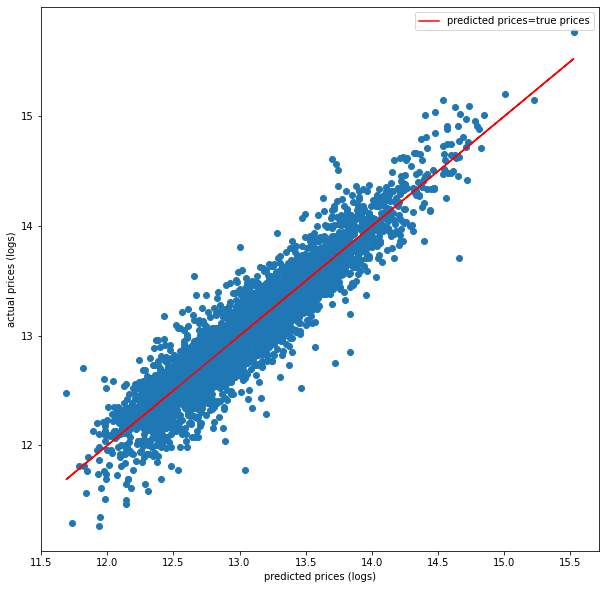

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_predict, y_test)
ax.plot(y_predict, y_predict, label='predicted prices=true prices', color='red')
ax.set_xlabel('predicted prices (logs)')
ax.set_ylabel('actual prices (logs)')
plt.legend()
plt.savefig('images/train_test_plot.png')
plt.show()

In [58]:
cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='r2'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='r2'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='r2'))

In [59]:
print('cross validation, 5 folds:', cv_5_results)
print('cross validation, 10 folds:', cv_10_results)
print('cross validation, 20 folds:', cv_20_results)

cross validation, 5 folds: 0.8810232549526844
cross validation, 10 folds: 0.880760584842743
cross validation, 20 folds: 0.8812268943823447


Just as with the previous model, mean cross validation R-squared scores are 0.3% below the scores we get from the data set as a whole.

### Calculating improvement factors for new model

In [60]:
print('minimum grade improvement factor, 97.5% confidence: ', np.e**0.097)
print('minimum condition improvement factor, 97.5% confidence: ', np.e**0.043)
print('minimum bathroom improvement factor, 97.5% confidence: ', np.e**0.039)
print('minimumum log_living_sqft improvement exponent, 97.5% confidence: ', 0.384)

minimum grade improvement factor, 97.5% confidence:  1.1018603736210106
minimum condition improvement factor, 97.5% confidence:  1.0439378948506126
minimum bathroom improvement factor, 97.5% confidence:  1.0397704836501578
minimumum log_living_sqft improvement exponent, 97.5% confidence:  0.384


Using the same improvements as the last time to predict a house's price increase, we get:

In [61]:
cv=200000

g = 1       #1 point increase in grade
c = 1       #1 point increase in condition
l = 1.1     #10% increase in square footage
b = 1       #1 additional bathroom

f = (1.10**g)*(1.04**c)*(1.04**b)*(l**0.384)

print('predicted appreciation factor :', f)
print('new value of home :', f*cv)
print('confidence :', 0.975**4) ## with only four variables we will have a higher degree of confidence

predicted appreciation factor : 1.2341108054304468
new value of home : 246822.16108608936
confidence : 0.9036878906249999


The factor for condition went down from 1.05 to 1.04, while the factor for square footage went up from 0.383 to 0.384.

The biggest change in this model is therefore the elimination of the renovation factor, which was raising the predicted price 9%.

By getting rid of this variable our estimated increase has gone down, but our confidence has increased from 88.1% to 90.4%.

#### What was the renovation variable doing?

The renovation variable clearly wasn't dependent on grade or condition, because if it was, eliminating it would have increased these variable's coefficients significantly. 

It also seemed to have a small overall effect on the model, accounting for only 0.1% of the model's R_squared.

This leaves the possibility there was a relationship between these renovation variables and zipcode variables, a hypothesis we can test by looking at the difference between zipcode coefficients in Models 4 and 5. If they increased significantly, this would indicate that renovations were more common in some neighborhoods than in others.

## Recommendations

### 1. Expected value of improvements.

Based on this analysis, we can use our model to make recommendations to our clients about the predicted value of specific types of home improvements, where each price increase factor is given with 97.5% confidence:

- 1 point grade increase: minimum 10% increase in price
- 1 point condition increase: minimum 4% increase in price
- 1 additional bathroom: minimum 4% increase in price
- 1% increase in living area: minimum ~0.038% increase in price
 

Below, we use the sample inputs from above to predict the appreciation of a 200,000 dollar house based on:

- 1 point grade increase
- 1 point condition increase
- 1 added bathroom
- 10% increase in living area

We then multiply this number by the product of the confidence levels for all four variables to calculate a risk-corrected expected return.

In [62]:
print('original value: ', 200000)
added_value = 200000*(1.10**g)*(1.04**c)*(1.04**b)*(l**0.384) - 200000
print('minimum added value of improvements (90.4% confidence): ', added_value)
print('risk-corrected expected return: ', added_value*0.904)

original value:  200000
minimum added value of improvements (90.4% confidence):  46822.161086089356
risk-corrected expected return:  42327.23362182478


Our clients should only do the proposed improvements if they can keep costs below the risk-corrected expected return of 42,327. 

If they want to add a bathroom without making any other changes, we get the following calculation:

In [63]:
print('original value: ', 200000)
added_value = 200000*(1.04) - 200000
print('minimum added value of improvements (97.5% confidence): ', added_value)
print('risk-corrected expected return: ', added_value*0.975)

original value:  200000
minimum added value of improvements (97.5% confidence):  8000.0
risk-corrected expected return:  7800.0


In this case the client should spend no more than 7,800 adding an additional bathroom.

### 2. Ideal Time of Year to Sell.

Houses sold in March go for an expected 5% above the January baseline, while houses sold in April go for an expected 7% above the January baseline. Consequently, clients are advised to try to sell their homes during these months.

## Further Questions

Comparing models 4 and 5 more closely could help to explain where the coefficients associated with the renovation bins are coming from. This could be done by plotting zipcode coefficients against the renovation rate per zipcode and seeing if these variables are correlated. 

If it turns out that there is no relationship between zipcode prices and renovation rate then we would probably be justified in assuming that renovation itself, independent of the specific improvements that renovation entails, is a significant factor in the price of a home.
